<a href="https://colab.research.google.com/github/Jectrianama/GCCE_TEST/blob/main/GoldStandard/golds_Wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Subclassing for GS

In [1]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import matplotlib.pyplot as plt
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_probability as tfp
from tensorflow.keras import regularizers
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split
tf.keras.backend.clear_session()
#tf.random.set_seed(42)
import types
import tempfile
class Keras_MA_GCCE(): #transformer no va
 #Constructor __init__. Special method: identified by a double underscore at either side of their name
 #work in the background
 # initialize data members to the object. lets the class initialize the object’s attributes and serves no other purpose.
    def __init__(self,epochs=100,batch_size=30,R=5, K=2, dropout=0.5, learning_rate=1e-3,optimizer='Adam', 
                  l1_param=0, validation_split=0.3, verbose=1, q = 0.1):
        self.epochs=epochs
        self.dropout=dropout
        self.batch_size = batch_size
        self.learning_rate=learning_rate 
        self.l1_param=l1_param 
        self.l2_param=l1_param
        self.validation_split = validation_split
        self.verbose = verbose
        self.optimizer = optimizer
        self.R=R
        self.K=K
        self.q = q

    
 
    def GCCE_MA_loss(self, y_true, y_pred):
        # print(y_true,y_pred)
       # q = 0.1
        pred = y_pred[:, self.R:]
        pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
        ann_ = y_pred[:, :self.R]
        # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
        Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
        Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)

        p_gcce = Y_true*(1 - Y_hat**self.q)/self.q
        temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)

        # p_logreg = tf.math.reduce_prod(tf.math.pow(Y_hat, Y_true), axis=1)
        # temp1 = ann_*tf.math.log(p_logreg)  
        # temp2 = (1 - ann_)*tf.math.log(1/K)*tf.reduce_sum(Y_true,axis=1)
        # aux = tf.repeat(tf.reduce_sum(pred*tf.math.log(pred),axis=1,keepdims=True), R, axis = 1)
        # tf.print(tf.shape(aux))
        # print(tf.shape(aux))
        # temp2 = (1 - ann_)*aux*tf.reduce_sum(Y_true,axis=1)
        # temp2 = (tf.ones(tf.shape(ann_)) - ann_)*tf.math.log(1/K)
        # print(tf.reduce_mean(Y_true,axis=1).numpy())
        # Y_true_1 = tf.clip_by_value(Y_true, clip_value_min=1e-9, clip_value_max=1)
        # p_logreg_inv = tf.math.reduce_prod(tf.math.pow(Y_true_1, Y_hat), axis=1)
        # temp2 = (1 - ann_)*tf.math.log(p_logreg_inv) 
        temp2 = (1 - ann_)*(1-(1/self.K)**self.q)/self.q*tf.reduce_sum(Y_true,axis=1)
        return tf.math.reduce_sum((temp1 + temp2))

 
    def PRI_MA_loss(self, y_true, y_pred): #,  -> PRI
        #Input ytrue: samples (N) x  annotators (R) 
        #Input ypred: samples (N) x  annotators+classes (R+K) 
        #PRI MA
        cce_M = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=-1)
        cce_C = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=1)

      

        #N = tf.cast(y_true.shape[0],dtype=tf.int32)
        N = tf.shape(y_true)[0]
        #Ground truth estimation samples (N) x  Classes(K)
        y_pred_tf = y_pred[:,self.R:] 
        # Annotators reliability prediction: samples (N) x  annotators (R)
        lambda_R_tf = y_pred[:,:self.R] #tf.ones(shape=(N,R)) 
        #Y_true 1 K: samples (N) x  Classes(1-K), annotators (R)
        Y_true_1K = tf.one_hot(tf.cast(y_true,dtype=tf.int32),depth=self.K,axis=1)  
        #Y_pred 1 - K: samples (N) x  Classes(1-K), annotators (R)
        Y_hat = tf.repeat(tf.expand_dims(y_pred_tf,-1), self.R, axis = -1) 
        #marginal entropy
        #cce along the K classes -> ypred_tf
        Hm_ = cce_M(y_pred_tf,y_pred_tf)
        #cross entropy
        #cce along the K classes -> Y_hat
        Hc_ = cce_C(Y_true_1K,Y_hat)
        #PRI MA computation
        LH = tf.linalg.matmul(lambda_R_tf,Hc_,transpose_a=True) # \Lambda^\top H_c
        temp1 = tf.linalg.trace(LH) #trace(LH)
        Hm1L = tf.linalg.matmul(tf.ones(shape=(N,self.R))-lambda_R_tf,tf.ones(shape=(self.R,1)))# 1_N 1_R^\top - Lambda
        Hm_t = tf.reshape(Hm_,shape=(N,1))
        temp2 = tf.squeeze(tf.linalg.matmul(Hm_t,Hm1L,transpose_a=True)) # Hm^\top Hm1L
        loss_c = temp1+ temp2 #return loss

        return loss_c

 
    def fit(self, X, Y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        P = X.shape[1]
        if self.optimizer == "Adam":
            opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate, clipnorm=1.0)
        elif self.optimizer == "SGD":
            opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate, clipnorm=1.0)
        else:
            opt=self.optimizer

        #capa de entrada
        input_l = tf.keras.layers.Input(shape=(X_train.shape[1]), name='entrada')
        #capas densas
        h1 = tf.keras.layers.Dense(int(P*4*(self.K+self.R)),activation='selu',name='h1',
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(input_l)#argumento de entrada
        h2 = tf.keras.layers.Dense(int(P*(self.K+self.R)),activation='selu',name='h2',
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(h1)
        dout = tf.keras.layers.Dropout(rate=self.dropout)(h2)
        #capa de salida
        output = tf.keras.layers.Dense(self.K,activation="softmax",name='output',
                                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(dout)
        self.model = tf.keras.Model(inputs= input_l,outputs=output)
        self.model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=opt,metrics="accuracy")
         
            
 
        self.history = self.model.fit(X, Y, epochs=self.epochs, validation_split=self.validation_split,   #
                                      batch_size=self.batch_size,verbose=self.verbose)
 
        return self
 
  
   
    def predict(self, X, *_):
       #input X numpy array first dimension samples (N)x features (P)
      return  self.model.predict(X) 
 
 

    def fit_predict(self,X,y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        self.fit(X,y)
        return self.predict(X)
  
     #graphics
    def plot_history(self):
        pd.DataFrame(self.history.history).plot(figsize=(8, 5))
        plt.grid(True)
        #plt.gca().set_ylim(0, 1)
        #save_fig("keras_learning_curves_plot")
        plt.show()
        return
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        return self
    
    
    
    def get_params(self, deep=True):
        return { 'l1_param':self.l1_param, 'dropout':self.dropout, 'optimizer':self.optimizer,
                'learning_rate':self.learning_rate, 'batch_size':self.batch_size,
                'epochs':self.epochs, 'verbose':self.verbose, 'validation_split':self.validation_split,
                'R':self.R, 'K':self.K, 'q':self.q
                }

  
        return self


In [2]:
#cargar datos desde drive acceso libre
FILEID = "1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW"
#https://drive.google.com/file/d/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW/view?usp=sharing
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O MADatasets.zip && rm -rf /tmp/cookies.txt
!unzip -o MADatasets.zip
!dir

--2023-02-03 05:38:52--  https://docs.google.com/uc?export=download&confirm=t&id=1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW
Resolving docs.google.com (docs.google.com)... 142.250.141.101, 142.250.141.102, 142.250.141.138, ...
Connecting to docs.google.com (docs.google.com)|142.250.141.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/110st9620u3llp4kcn2hdvvpusdrf0v9/1675402725000/07591141114418430227/*/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW?e=download&uuid=cf94803b-3e4e-462c-bea7-1c56d9ac41e8 [following]
--2023-02-03 05:38:52--  https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/110st9620u3llp4kcn2hdvvpusdrf0v9/1675402725000/07591141114418430227/*/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW?e=download&uuid=cf94803b-3e4e-462c-bea7-1c56d9ac41e8
Resolving doc-00-90-docs.googleusercontent.com (doc-00-90-docs.googleusercontent.com)... 142.250.141.

# Load Data

In [3]:
#load data
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf #importar tensorflow
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
database = 'Wine' #['bupa1', 'breast-cancer-wisconsin1','pima-indians-diabetes1', 'ionosphere1', 'tic-tac-toe1', 'iris1', 'wine1', 'segmentation1']


path_ = 'MADatasets/'+ database+ '.mat' 
Xdata = sio.loadmat(path_)
Xdata.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Y', 'iAnn', 'Exp', 'idxtr', 'idxte'])

In [4]:
X = Xdata['X']
Y = Xdata['Y']
t = Xdata['y'].reshape(-1)
print('X',X.shape,'t',t.shape,'Y',Y.shape)
 

X (178, 13) t (178,) Y (178, 5)


In [5]:
t 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3], dtype=uint8)

In [6]:
t = t - 1

# Split data

In [7]:
import numpy.matlib
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
Ns = 1
ss = ShuffleSplit(n_splits=Ns, test_size=0.3,random_state =123)
for train_index, test_index in ss.split(X):
    print(test_index)
    X_train, X_test,Y_train,Y_test = X[train_index,:], X[test_index,:],Y[train_index,:], Y[test_index,:]
    Y_true_train, Y_true_test = t[train_index].reshape(-1,1), t[test_index].reshape(-1,1)
print(X_train.shape, Y_train.shape, Y_true_train.shape)

[138  60 137  77  90 159  41 136 166  93 154 141 164  33  31 152  82 122
  42  87 139 147 151 162  79 169 157  95  53  10  23  37 134 110 167 120
 142   8  72 114 148 163  36  20 121  28  13  88  24 100 127 143 144  85]
(124, 13) (124, 5) (124, 1)


# Apply MinMaxScaler

In [8]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Testing the Class 


iteration: 0


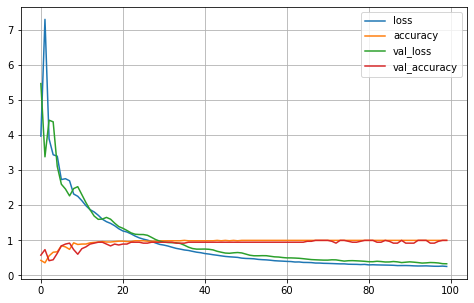

2/2 [==============================] - 0s 12ms/step
Validation ACC: 0.9630
Validation Balanced_ACC: 0.9495
Validation MI: 0.9425
Validation Normalized MI: 0.8681
Validation Adjusted MI: 0.8631
Validation aUc: 0.9875
iteration: 1


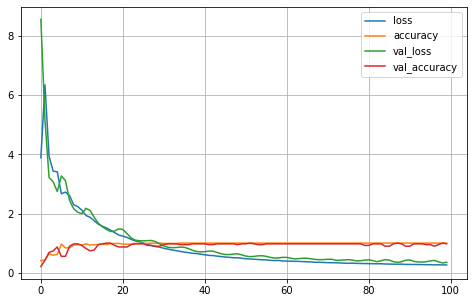

2/2 [==============================] - 0s 6ms/step
Validation ACC: 0.9815
Validation Balanced_ACC: 0.9722
Validation MI: 1.0140
Validation Normalized MI: 0.9356
Validation Adjusted MI: 0.9332
Validation aUc: 0.9875
iteration: 2


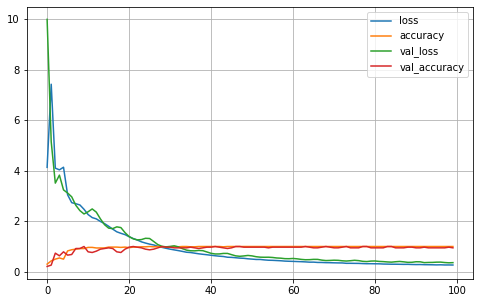

2/2 [==============================] - 0s 7ms/step
Validation ACC: 0.9815
Validation Balanced_ACC: 0.9722
Validation MI: 1.0140
Validation Normalized MI: 0.9356
Validation Adjusted MI: 0.9332
Validation aUc: 0.9875
iteration: 3


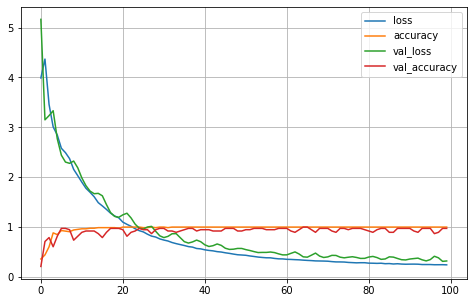

2/2 [==============================] - 0s 4ms/step
Validation ACC: 0.9630
Validation Balanced_ACC: 0.9495
Validation MI: 0.9425
Validation Normalized MI: 0.8681
Validation Adjusted MI: 0.8631
Validation aUc: 0.9875
iteration: 4


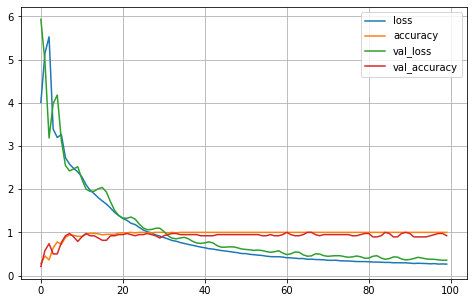

2/2 [==============================] - 0s 6ms/step
Validation ACC: 0.9815
Validation Balanced_ACC: 0.9722
Validation MI: 1.0140
Validation Normalized MI: 0.9356
Validation Adjusted MI: 0.9332
Validation aUc: 0.9875
iteration: 5


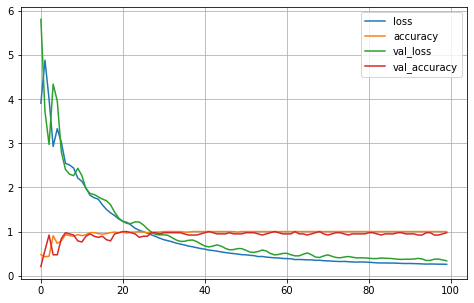

2/2 [==============================] - 0s 7ms/step
Validation ACC: 0.9815
Validation Balanced_ACC: 0.9773
Validation MI: 1.0095
Validation Normalized MI: 0.9318
Validation Adjusted MI: 0.9292
Validation aUc: 1.0000
iteration: 6


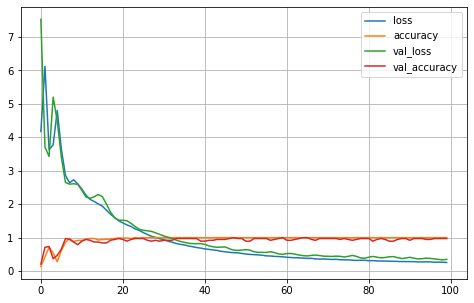

2/2 [==============================] - 0s 4ms/step
Validation ACC: 0.9630
Validation Balanced_ACC: 0.9495
Validation MI: 0.9425
Validation Normalized MI: 0.8681
Validation Adjusted MI: 0.8631
Validation aUc: 0.9875
iteration: 7


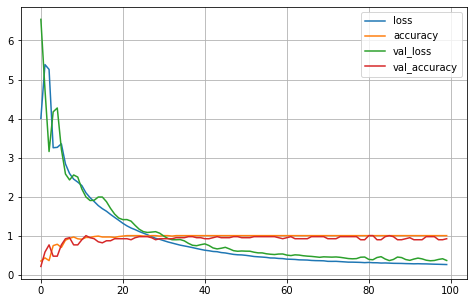

2/2 [==============================] - 0s 10ms/step
Validation ACC: 0.9815
Validation Balanced_ACC: 0.9722
Validation MI: 1.0140
Validation Normalized MI: 0.9356
Validation Adjusted MI: 0.9332
Validation aUc: 0.9875
iteration: 8


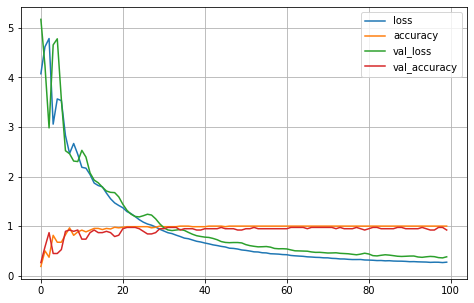

2/2 [==============================] - 0s 7ms/step
Validation ACC: 0.9815
Validation Balanced_ACC: 0.9722
Validation MI: 1.0140
Validation Normalized MI: 0.9356
Validation Adjusted MI: 0.9332
Validation aUc: 0.9875
iteration: 9


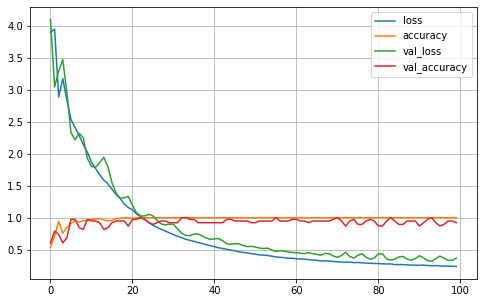

2/2 [==============================] - 0s 6ms/step
Validation ACC: 0.9815
Validation Balanced_ACC: 0.9722
Validation MI: 1.0140
Validation Normalized MI: 0.9356
Validation Adjusted MI: 0.9332
Validation aUc: 0.9875


In [9]:
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
l1 =0.001
NUM_RUNS =10
ACC = np.zeros(NUM_RUNS)
AUC = np.zeros(NUM_RUNS)
MI = np.zeros(NUM_RUNS)
NMI = np.zeros(NUM_RUNS)
AMI = np.zeros(NUM_RUNS)
BACC = np.zeros(NUM_RUNS)
for i in range(NUM_RUNS): #10
    print("iteration: " + str(i))
   
    MA = Keras_MA_GCCE(epochs=100,batch_size=256,R=5, K=len(np.unique(Y_true_train)), dropout=0.25, learning_rate=0.01,optimizer='Adam', 
                l1_param=l1,  validation_split=0.30, verbose=0, q=0.1)

    
    MA.fit(X_train,  Y_true_train)
    MA.plot_history()
  
    #Accuracy
    pred_2 = MA.predict(X_test)
 
    report = classification_report( pred_2.argmax(axis=1),Y_true_test.ravel(),output_dict=True)
    ACC[i] = report['accuracy']
    print("Validation ACC: %.4f" % (float(ACC[i])))


    # balanced. Accurcy
    BACC[i] = balanced_accuracy_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze(), adjusted=True)
    print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))

    #MI
    
    MI[i] = mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
    print("Validation MI: %.4f" % (float(MI[i]),))
    NMI[i] = normalized_mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
    print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
    AMI[i]= adjusted_mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
    print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))


    #AUC
    val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)  
   # val_logits =MA.predict(X_test) # model(X_test, training=False)
    # tf.print(y_batch_val)
    val_AUC_metric.update_state(Y_true_test, pred_2.argmax(axis=1).astype('float'))

    val_AUC = val_AUC_metric.result()
    val_AUC_metric.reset_states()
    val_AUC = val_AUC.numpy()
    print("Validation aUc: %.4f" % (float(val_AUC),))
    AUC[i] = val_AUC
    

In [11]:
ACC

array([0.96296296, 0.98148148, 0.98148148, 0.96296296, 0.98148148,
       0.98148148, 0.96296296, 0.98148148, 0.98148148, 0.98148148])

In [12]:

AUC

array([0.98750001, 0.98750001, 0.98750001, 0.98750001, 0.98750001,
       1.        , 0.98750001, 0.98750001, 0.98750001, 0.98750001])

In [13]:
print('Average Accuracy: ', np.round( ACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( ACC),4)*100)
print('==============================================')
print('Average AUC: ', np.round( AUC.mean(),4)*100) 
print('Average AUC std: ',np.round(np.std( AUC),4)*100)
print('==============================================')
print('Average Balanced Accuracy: ', np.round( BACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( BACC),4)*100)
print('==============================================')
print('Average MI: ', np.round( MI.mean(),4)*100) 
print('Average std: ',np.round(np.std(MI),4)*100)
print('==============================================')
print('Average Normalized MI: ', np.round( NMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(NMI),4)*100)
print('==============================================')
print('Average Ajdusted MI: ', np.round( AMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(AMI),4)*100)

Average Accuracy:  97.59
Average std:  0.8500000000000001
Average AUC:  98.88
Average AUC std:  0.37
Average Balanced Accuracy:  96.59
Average std:  1.08
Average MI:  99.21
Average std:  3.25
Average Normalized MI:  91.5
Average std:  3.0700000000000003
Average Ajdusted MI:  91.18
Average std:  3.19
